# Initial EDA for Masters Thesis On Policy Effects on Site-Level Emissions

## Research question / Hypotheses

**Core question:**
> How do discrete environmental policy interventions affect local air-quality outcomes—measured via satellite-derived NO₂—around major industrial and power-sector emitters across the US and EU?

**Sub-questions / hypotheses:**
- *H1:* Implementation of air-quality regulations (e.g., CSAPR, IED) reduces tropospheric NO₂ in buffers surrounding treated facilities.
- *H2:* The magnitude of NO₂ reduction correlates with plant characteristics (fuel type, capacity, presence of controls) and local geography (AlphaEarth embeddings).
- *H3:* Seasonal and meteorological conditions (ERA5 winds, boundary layer height) moderate observed changes.

We expect to observe **downward trends** in NO₂ near coal-dominated facilities post-policy and smaller or mixed effects near gas-fired or already-compliant plants.

# Overview of Datasets

| Dataset | Temporal Resolution | Role | Notes / Links |
|---|---|---|---|
| **EIA-860 (annual)** | Yearly | Static attributes for **US** plants (capacity, primary fuel, optional controls via EnviroAssoc) | Authoritative plant inventory. Used to build the US facility universe and geocodes. [EIA-860](https://www.eia.gov/electricity/data/eia860/) |
| **EIA-860M (monthly)** | Monthly | Operating status / temporal changes | Aligns facility×month activity if we need on/off status. [EIA-860M](https://www.eia.gov/electricity/data/eia860m/) |
| **EPA FRS** (optional) | Static | Alternate facility geocodes | Only needed to patch coordinates. [FRS](https://www.epa.gov/frs) |
| **EEA Industrial Emissions Portal – LCP** | Annual (wide) | **EU** large-combustion plant attributes & coordinates | EU plant universe. We harmonize to plant-level `capacity_mw` and a coarse `fuel_primary`. [EEA LCP](https://industry.eea.europa.eu/explore/explore-lcp) |
| **US policy coverage (ARP/CSAPR)** | Annual program coverage → **monthly flags** | Policy exposure for **US EGUs** | Pulled from the **EPA EASEY Facilities API**. Canonical codes used: `ARP`, `CSNOX` (annual NOx), `CSNOXOS` (ozone-season NOx), `CSOSG1`, `CSOSG2` (SO₂ G1/G2). We scope to **Electric Utility** or records with an **ORIS** code. Exact effective dates encoded (e.g., `CSNOXOS` starts **May 1** each year). |
| **EU policy coverage (EU ETS)** | First compliance year → **monthly flags** | Installation-level exposure for **EU stationary ETS** | Loaded from **EUETS.INFO extracts** via `pyeutl.ziploader`. We keep stationary activities (power/industry) and **exclude aviation/maritime/ESD** using `activity_types.csv`. Effective date = **Jan 1 of first compliance year** for each installation. |
| **TROPOMI NO₂ (S5P)** | Daily → Monthly | Outcome variable | Tropospheric NO₂ column density aggregated in Earth Engine. |
| **ERA5 monthly** | Monthly | Meteorological controls | Wind, PBLH, temperature, precip. |
| **AlphaEarth (10 m, 64-D annual)** | Annual | Geographic embedding controls | Land-use / context embeddings. |

**Notes on policy timing (we encode exactly):**
- **US**: `ARP`, `CSNOX`, `CSOSG1`, `CSOSG2` ⇒ **Jan 1** of earliest covered year; `CSNOXOS` (ozone season) ⇒ **May 1** of earliest covered year and **active only May–Sept** each year.
- **EU ETS**: annual cap — we use **Jan 1** of the first year an installation appears in compliance (treats all months in/after that year).


### Schema Sketch for Policy Panel
```
policy_id         : str   # unique
policy_name       : str
policy_class      : str   # 'cap' | 'standard' | 'lez' | 'other'
sector            : str   # 'power' | 'industry' | 'transport'
region_type       : str   # 'state' | 'country' | 'city'
region_code       : str   # e.g., 'TX', 'DE', city slug
effective_date    : str   # 'YYYY-MM-DD'
season_start_month: int   # 1..12 or blank (NA)
season_end_month  : int   # 1..12 or blank (NA)
source_url        : str
```

From these, we derive flags per facility: `treat_any`, and class-specific `treat_cap`, `treat_standard`, `treat_lez`.


## Variables: Rough Causal Diagram
Outcome: **monthly NO₂ near facilities** $E_{it}$. 
Causes: **policy exposure** $P_{it}$, **plant characteristics** $X_i$, **geographic context**
$G_{it}$, **weather/transport** $W_{it}$. 
Lobbying $L_{rt}$ shapes policy and moderates effects. 
We will estimate staggered-adoption event-studies with facility and month FE.

```mermaid
flowchart LR
  subgraph Unobserved Confounders
    direction TB
    Ur(U_rt)
    Ui(U_i)
    Ut(U_t)
  end
  subgraph Exposures / Confounders
    direction TB
    L[Lobbying L_rt]
    X[Plant traits X_i]
    G[Geo context embedding G_it]
    W[Weather / transport W_it]
  end
  subgraph Policies
    direction TB
    P[Policy P_it]
  end
  subgraph Outcome
    direction TB
    E[NO2 outcome E_it]
  end
  Ur -.-> L
  Ui -.-> X
  Ut -.-> P
  Ut -.-> E
  L --> P
  X --> P
  G --> P
  W --> P
  P --> E
  X --> E
  G --> E
  W --> E
  L -.-> E
```

## Load facilities and construct plant attributes

### USA EIA-860 (2024) files and columns:

- **Plant** — `2___Plant_Y2024.xlsx` 
  Columns we use: **Plant Code**, **Plant Name**, **State**, **Latitude**, **Longitude**.  
  *(Coordinates live here)*

- **Generators (Operable)** — `3_1_Generator_Y2024.xlsx` (sheet **Operable**, header row at index 1)  
  Columns we use: **Plant Code**, **Nameplate Capacity (MW)**, **Energy Source 1**.  
  *(Early simplification: we aggregate generator capacity to plants and infer a plant’s primary fuel.)*

- **EnviroAssoc (optional abatement flags)** — `6_1_EnviroAssoc_Y2024.xlsx` (sheet **Emissions Control Equipment**, header row at index 1)  
  Columns we use: **Plant Code**, **Equipment Type** (coded).  
  Codes (from **LayoutY2024 → Reference Tables 7–9, Table 7**):  
  - **SR** = Selective Catalytic Reduction → `has_scr=1`  
  - **SN** = Selective Non-Catalytic Reduction → `has_sncr=1`  
  - **SD** = Spray dryer / dry FGD / semi-dry FGD; **CD** = Circulating dry scrubber → `has_fgd=1`  


In [47]:
import pandas as pd, numpy as np, os

OUT = "data/out"
os.makedirs(OUT, exist_ok=True)

# --- PLANT (coords, state, id) ---
plant_path = "data/eia8602024/2___Plant_Y2024.xlsx"
plant_us = pd.read_excel(plant_path, sheet_name="Plant", header=1,
                         usecols=["Plant Code","Plant Name","State","Latitude","Longitude"])
plant_us = plant_us.rename(columns={"Plant Code":"plant_id","Plant Name":"name","State":"state",
                                    "Latitude":"lat","Longitude":"lon"})
plant_us["country"] = "US"
plant_us["country_code"] = plant_us["state"]

# --- GENERATORS (capacity, fuel) ---
gen_path = "data/eia8602024/3_1_Generator_Y2024.xlsx"
gen_us = pd.read_excel(gen_path, sheet_name="Operable", header=1,
                       usecols=["Plant Code","Nameplate Capacity (MW)","Energy Source 1"])
gen_us = gen_us.rename(columns={"Plant Code":"plant_id","Nameplate Capacity (MW)":"cap_mw",
                                "Energy Source 1":"fuel1"})
gen_us["cap_mw"] = pd.to_numeric(gen_us["cap_mw"], errors="coerce")

# Aggregate capacity to plant; choose primary fuel by capacity share. NOTE: Simplification for now.
agg_cap = gen_us.groupby("plant_id", as_index=False)["cap_mw"].sum().rename(columns={"cap_mw":"capacity_mw"}) # type: ignore
top_fuel = (gen_us.groupby(["plant_id","fuel1"], as_index=False)["cap_mw"].sum()
                  .sort_values(["plant_id","cap_mw"], ascending=[True,False]) # type: ignore
                  .drop_duplicates("plant_id")[["plant_id","fuel1"]]
                  .rename(columns={"fuel1":"fuel_primary"})) # type: ignore

# --- ENVIROASSOC abatement flags ---
# Sheet: "Emissions Control Equipment" • columns: Plant Code, Equipment Type
flags = pd.DataFrame(columns=["plant_id","has_scr","has_sncr","has_fgd"]) # type: ignore
env_path = "data/eia8602024/6_1_EnviroAssoc_Y2024.xlsx"
env = pd.read_excel(env_path, sheet_name="Emissions Control Equipment", header=1,
                        usecols=["Plant Code","Equipment Type"])
env = env.rename(columns={"Plant Code":"plant_id","Equipment Type":"equip_code"})
env["equip_code"] = env["equip_code"].astype(str).str.upper().str.strip()

def any_in(series, codes):
    s = series.dropna().astype(str).str.upper().str.strip()
    return int(s.isin(codes).any())

flags = (env.groupby("plant_id")
            .agg(has_scr=("equip_code", lambda s: any_in(s, {"SR","SR-2"})),
                has_sncr=("equip_code", lambda s: any_in(s, {"SN"})),
                has_fgd=("equip_code", lambda s: any_in(s, {"SD","CD"})))
            .reset_index())

# ----- Merge to US plant table -----
plant_us = (plant_us
            .merge(agg_cap, on="plant_id", how="left")
            .merge(top_fuel, on="plant_id", how="left")
            .merge(flags,   on="plant_id", how="left"))

# Clean types/defaults + ensure one row per plant
plant_us["capacity_mw"] = plant_us["capacity_mw"].fillna(0)
plant_us["fuel_primary"] = plant_us["fuel_primary"].fillna("Unknown")
for c in ["has_scr","has_sncr","has_fgd"]:
    if c not in plant_us.columns: plant_us[c] = 0
    plant_us[c] = plant_us[c].fillna(0).astype(int)

# Drop any artefact columns if you previously ran older code
plant_us = plant_us.drop(columns=["equip","level_1"], errors="ignore")
plant_us = plant_us.drop_duplicates(subset=["plant_id"])

In [48]:
plant_us.head(20)

,plant_id,name,state,lat,lon,country,country_code,capacity_mw,fuel_primary,has_scr,has_sncr,has_fgd
0,1,Sand Point,AK,55.339722,-160.497222,US,AK,3.7,DFO,0,0,0
1,2,Bankhead Dam,AL,33.458665,-87.356823,US,AL,53.9,WAT,0,0,0
2,3,Barry,AL,31.0069,-88.0103,US,AL,3343.5,NG,1,1,0
3,4,Walter Bouldin Dam,AL,32.583889,-86.283056,US,AL,225.0,WAT,0,0,0
4,7,Gadsden,AL,34.0128,-85.9708,US,AL,0.0,Unknown,0,0,0
5,8,Gorgas,AL,33.644344,-87.196486,US,AL,0.0,Unknown,1,0,0
6,9,Copper,TX,31.7569,-106.375,US,TX,86.9,NG,0,0,0
7,10,Greene County,AL,32.6017,-87.7811,US,AL,1288.4,NG,0,0,0
8,11,H Neely Henry Dam,AL,33.7845,-86.0524,US,AL,72.9,WAT,0,0,0
9,12,Holt Dam,AL,33.2553,-87.4495,US,AL,46.9,WAT,0,0,0


### EU plants (EEA Large Combustion Plants)

We load **`data/eu_lcp/EEA_Industry_Dataset_LCP.xlsx`** and pick columns robustly (the LCP workbook can change sheet/column labels across releases). We harmonise to:

- `plant_id`, `name`, `lat`, `lon`, `country_code`
- `capacity_mw` (uses available capacity or **rated thermal input** as a proxy if needed)
- `fuel_primary`

Abatement flags are **not** available in LCP; we set `has_scr`, `has_sncr`, `has_fgd` to `NaN` for EU rows.


In [49]:
# --- EU plants (deterministic from LCP_Energy_Emissions) ---
import pandas as pd, numpy as np, re

EU_DIR = "data/eu_lcp"
eu_path = f"{EU_DIR}/EEA_Industry_Dataset_LCP.xlsx"

# Read single sheet deterministically
df = pd.read_excel(eu_path, sheet_name="LCP_Energy_Emissions", dtype={"LCPInspireId": str})

# Years in wide format
year_cols = [c for c in df.columns if re.fullmatch(r"\d{4}", str(c)) and 2016 <= int(c) <= 2023]

# Derive ISO-2 from the ID prefix like 'AT.CAED/...'
df["country_code"] = df["LCPInspireId"].str.split(".").str[0].str.upper()

# -------------------------
# Capacity (MW): take rows where featureType='LCPCharacteristics' & unit='MW'
# -------------------------
cap_rows = df[(df["featureType"] == "LCPCharacteristics") & (df["unit"].str.upper() == "MW")].copy()
cap_rows["capacity_mw"] = cap_rows[year_cols].max(axis=1, skipna=True)
cap = (cap_rows
       .groupby("LCPInspireId", as_index=False)
       .agg(capacity_mw=("capacity_mw","max"),
            name=("installationPartName","first"),
            lon=("Longitude","first"),
            lat=("Latitude","first"),
            country_code=("country_code","first")))

# -------------------------
# Primary fuel: pick the energy carrier (TJ) with the largest total across years
# -------------------------
FUEL_FEATURES = [
    "Coal","Lignite","OtherSolidFuels","NaturalGas",
    "LiquidFuels","OtherGases","Peat","Biomass"
]
fuel_rows = df[df["featureType"].isin(FUEL_FEATURES) & (df["unit"].str.upper() == "TJ")].copy()
if not fuel_rows.empty:
    fuel_rows["energy_tj_total"] = fuel_rows[year_cols].sum(axis=1, skipna=True) # type: ignore
    fuel_tot = (fuel_rows.groupby(["LCPInspireId","featureType"], as_index=False)
                          .agg(energy_tj_total=("energy_tj_total","sum")))
    fuel_primary = (fuel_tot.sort_values(["LCPInspireId","energy_tj_total"], ascending=[True, False]) # type: ignore
                           .drop_duplicates("LCPInspireId")
                           .rename(columns={"featureType":"fuel_primary"})
                           [["LCPInspireId","fuel_primary"]])
else:
    # If no TJ rows are present, set fuel_primary to NaN
    fuel_primary = cap[["LCPInspireId"]].assign(fuel_primary=np.nan)

# -------------------------
# Harmonise to EU plant table 
# -------------------------
plant_eu = (cap.merge(fuel_primary, on="LCPInspireId", how="left")
         .rename(columns={
             "LCPInspireId":"plant_id",
             "name":"name",
             "lat":"lat",
             "lon":"lon"
         }))

plant_eu["country"] = "EU"
plant_eu["fuel_primary"] = plant_eu["fuel_primary"].astype(object)
# Abatement flags not provided in LCP sheet
plant_eu["has_scr"] = np.nan
plant_eu["has_sncr"] = np.nan
plant_eu["has_fgd"] = np.nan

plant_eu = plant_eu[["country","country_code","plant_id","name","lat","lon",
         "capacity_mw","fuel_primary","has_scr","has_sncr","has_fgd"]].copy()

In [50]:
plant_eu.head(20)

,country,country_code,plant_id,name,lat,lon,capacity_mw,fuel_primary,has_scr,has_sncr,has_fgd
0,EU,AT,AT.CAED/9008390225387.PART,Sodakessel 3,48.183917,14.257667,98.0,OtherSolidFuels,NaN,NaN,NaN
1,EU,AT,AT.CAED/9008390225462.PART,Gaskessel,48.183917,14.257667,66.0,NaturalGas,NaN,NaN,NaN
2,EU,AT,AT.CAED/9008390225660.PART,Kesselanlage 2,48.721250,16.278111,50.0,NaturalGas,NaN,NaN,NaN
3,EU,AT,AT.CAED/9008390264584.PART,100 to-Kessel,48.070278,14.808389,83.0,NaturalGas,NaN,NaN,NaN
4,EU,AT,AT.CAED/9008390317877.PART,Laugekessel 2K7,47.975500,13.616778,100.0,OtherSolidFuels,NaN,NaN,NaN
5,EU,AT,AT.CAED/9008390317891.PART,Laugekessel 2K6,47.975500,13.616778,67.0,OtherSolidFuels,NaN,NaN,NaN
6,EU,AT,AT.CAED/9008390325254.PART,Laugekessel 2K10,47.975500,13.616778,103.0,OtherSolidFuels,NaN,NaN,NaN
7,EU,AT,AT.CAED/9008390325773.PART,Gaskessel 1K6,47.975500,13.616778,124.0,NaturalGas,NaN,NaN,NaN
8,EU,AT,AT.CAED/9008390333020.PART,RS10 Rohöldestillation 4,48.144333,16.490472,180.0,OtherGases,NaN,NaN,NaN
9,EU,AT,AT.CAED/9008390333044.PART,RS13 FCC-Anlage,48.144333,16.490472,102.0,OtherSolidFuels,NaN,NaN,NaN


### Merged

In [51]:
fac = pd.concat([
    plant_us[["country","country_code","plant_id","name","lat","lon",
              "capacity_mw","fuel_primary","has_scr","has_sncr","has_fgd"]],
    plant_eu
], ignore_index=True)

fac.sample(20)


,country,country_code,plant_id,name,lat,lon,capacity_mw,fuel_primary,has_scr,has_sncr,has_fgd
8965,US,NE,61407,Cottonwood Wind Energy Center,40.240168,-98.405956,89.7,WND,0.0,0.0,0.0
7352,US,CA,59536,Coronus Adelanto West 1,34.548056,-117.464444,1.5,SUN,0.0,0.0,0.0
9480,US,MI,61954,Delta Solar Power I,42.7,-84.701,8.1,SUN,0.0,0.0,0.0
12155,US,TX,64897,WAL3285,32.59732,-96.946914,1.2,NG,0.0,0.0,0.0
4332,US,WY,55607,Foote Creek I,41.6283,-106.2013,0.0,Unknown,0.0,0.0,0.0
11588,US,GA,64280,Meriwether Jackson,32.877496,-84.644367,3.0,SUN,0.0,0.0,0.0
10251,US,OK,62837,Frontier Windpower II,36.82478,-97.029777,351.8,WND,0.0,0.0,0.0
5339,US,AR,57161,White River Lock and Dam 2,35.744036,-91.765418,3.5,WAT,0.0,0.0,0.0
11364,US,OR,64048,SulusSolar29,45.46,-122.29,2.6,SUN,0.0,0.0,0.0
13284,US,TX,66137,Zier Solar,29.350992,-100.562028,200.4,SUN,0.0,0.0,0.0


### Facility structure — quick EDA
We examine distributions and composition to understand where identification strength may come from (coal/gas capacity, right tails, region mix).

,count,mean,50%,max
country,,,,
EU,4484.0,358.11,146.5,9611.3
US,16132.0,82.12,4.5,6809.0


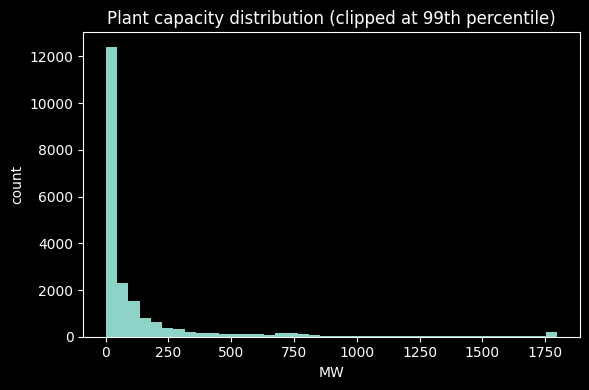

country,EU,US
fuel_group_top,,
Gas,0.482,0.122
Solar,0.000,0.392
Other/Unknown,0.000,0.208
Other,0.128,0.033
Oil,0.106,0.053
Biomass,0.150,0.007
Coal,0.134,0.013
Hydro,0.000,0.088
Wind,0.000,0.083


,country,fuel_group,n
16,US,Solar,6331
15,US,Other/Unknown,3350
2,EU,Gas,2160
9,US,Gas,1963
11,US,Hydro,1425
18,US,Wind,1344
13,US,Oil,859
0,EU,Biomass,674
1,EU,Coal,600
4,EU,Other gas,514


In [52]:
import matplotlib.pyplot as plt

# Ensure numeric capacity and nonnegative
fac['capacity_mw'] = pd.to_numeric(fac['capacity_mw'], errors='coerce').fillna(0).clip(lower=0) # type: ignore

# Normalise fuel labels across US (codes) and EU (strings)
def fuel_group_map(x: object) -> str:
    s = str(x).strip().upper()
    if s in {'NATURALGAS','NG'}: return 'Gas'
    if s in {'COAL','PC','COW','COL','BIT','SUB','ANT','LIGNITE','LIG','WC','RC'}: return 'Coal'
    if s in {'LIQUIDFUELS','DFO','RFO','KER','JF','OIL'}: return 'Oil'
    if s in {'OTHERGASES','OBG'}: return 'Other gas'
    if s in {'OTHERSOLIDFUELS','OTHER SOLID FUELS','OSF'}: return 'Other solid'
    if s in {'BIOMASS','WDL','WDS','AB'}: return 'Biomass'
    if s in {'PEAT'}: return 'Peat'
    if s in {'NUC','NUCLEAR'}: return 'Nuclear'
    if s in {'SUN','SOLAR'}: return 'Solar'
    if s in {'WND','WIND'}: return 'Wind'
    if s in {'WAT','HYDRO'}: return 'Hydro'
    if s in {'GEO','GEOTHERMAL'}: return 'Geothermal'
    if s in {'MSW','LFG','TDF'}: return 'Waste'
    return 'Other/Unknown'

fac['fuel_group'] = fac['fuel_primary'].apply(fuel_group_map)

# --- Summary table by country ---
summary = fac.groupby('country', dropna=False)['capacity_mw'].describe()[['count','mean','50%','max']].round(2)
display(summary)

# --- Capacity distribution (clip 99th to reduce distortion from mega plants) ---
plt.figure(figsize=(6,4))
fac['capacity_mw'].clip(upper=fac['capacity_mw'].quantile(0.99)).plot(kind='hist', bins=40) # type: ignore
plt.title('Plant capacity distribution (clipped at 99th percentile)')
plt.xlabel('MW'); plt.ylabel('count'); plt.tight_layout(); plt.show()

# --- Composition by fuel group and country (top groups + Other) ---
top_groups = fac['fuel_group'].value_counts().head(8).index.tolist()
fac['fuel_group_top'] = np.where(fac['fuel_group'].isin(top_groups), fac['fuel_group'], 'Other')

# counts → shares without multiindex-reset pitfalls
comp_counts = (fac.groupby(['country','fuel_group_top'], dropna=False) 
                 .size()
                 .reset_index(name='n')) # type: ignore
comp = comp_counts.assign(
    share = comp_counts['n'] / comp_counts.groupby('country')['n'].transform('sum')
)[['country','fuel_group_top','share']]

# Pivot for a quick overview, sorted by overall prevalence
pivot = comp.pivot(index='fuel_group_top', columns='country', values='share').fillna(0)
pivot = pivot.assign(_sum=pivot.sum(axis=1)).sort_values('_sum', ascending=False).drop(columns='_sum')
display(pivot.round(3).head(15))

# --- Top 12 counts by (country, fuel_group) for a quick glance ---
cnt = (fac.groupby(['country','fuel_group'], dropna=False)
         .size()
         .reset_index(name='n') # type: ignore
         .sort_values('n', ascending=False))
display(cnt.head(12))


## Load parameterised policy exposures (US + EU)

We ingest policy CSVs and derive **monthly facility exposure flags**:
- `treat_any` — any applicable policy active.
- `treat_cap`, `treat_standard`, `treat_lez` — class-specific active flags.

**Mapping logic:**
1) **Sector match**: facilities treated as `power` by default (EIA/LCP focus).  
2) **Region match**: US by `state` (our `country_code`), EU by member-state `country_code` (or city for LEZ when available).  
3) **Time**: active if `month >= effective_date` and, if seasonal windows exist, if the month is within `[season_start_month, season_end_month]` (wrap across year allowed).


In [53]:
import os
import time
import requests
import pandas as pd
from typing import Dict, Iterable, List, Sequence
from pandas import Timestamp

US_PROGRAM_START = {
    "ARP":   (1, 1),  # annual
    "CSOS":  (1, 1),  # annual SO2
    "CSNOX": (5, 1),  # NOx Ozone Season starts May 1
}

API_BASE = "https://api.epa.gov/easey/facilities-mgmt/facilities/attributes"
API_KEY  = "IY73y2OB1kOtIJMFru4zA4DhHhSsSXQJKBLpOy1K"

# Canonical program codes we care about
VALID_CODES = {"ARP", "CSNOX", "CSNOXOS", "CSOSG1", "CSOSG2"}

# Friendly aliases -> one or more canonical codes
ALIAS_MAP = {
    "CSOS":   ("CSOSG1", "CSOSG2"),   # CSAPR SO2 is split in API
    "NOXOS":  ("CSNOXOS",),           # ozone season NOx
    "NOXANN": ("CSNOX",),             # annual NOx
}

# Correct program effective start dates
US_PROGRAM_START = {
    "ARP":     (1, 1),
    "CSNOX":   (1, 1),  # annual NOx
    "CSNOXOS": (5, 1),  # ozone-season NOx
    "CSOSG1":  (1, 1),
    "CSOSG2":  (1, 1),
}

def _expand_program_codes(codes: Iterable[str]) -> List[str]:
    out: List[str] = []
    for c in codes:
        c_up = str(c).upper()
        if c_up in ALIAS_MAP:
            out.extend(ALIAS_MAP[c_up])
        else:
            out.append(c_up)
    # keep only known codes, preserve order, drop dups
    seen = set()
    keep: List[str] = []
    for c in out:
        if c in VALID_CODES and c not in seen:
            keep.append(c); seen.add(c)
    return keep

def _start_date_for_policy(code, year):
    if pd.isna(year):
        return pd.NaT
    m, d = US_PROGRAM_START.get(code, (1, 1))
    return Timestamp(year=int(year), month=m, day=d)

def _req(url: str, params: Dict, max_retries: int = 3) -> requests.Response:
    headers = {"Accept": "application/json"}
    if API_KEY:
        params = {**params, "api_key": API_KEY}
    for i in range(max_retries):
        r = requests.get(url, params=params, timeout=60, headers=headers) 
        if r.status_code in (429, 500, 502, 503, 504):
            time.sleep(1.5 * (i + 1))
            continue
        if r.status_code >= 400:
            snippet = (r.text or "")[:500]
            raise requests.HTTPError(f"{r.status_code} {r.reason} for {r.url}\n{snippet}", response=r)
        return r
    r.raise_for_status() #type: ignore
    return r  #type: ignore

def _fetch_all_facility_attributes(year: int, program_code: str, per_page: int = 500) -> List[Dict]:
    page, out = 1, []
    while True:
        params = {"year": year, "programCodeInfo": program_code, "perPage": per_page, "page": page}
        r = _req(API_BASE, params)
        js = r.json() or []
        if not js:
            break
        out.extend(js)
        if len(js) < per_page:
            break
        page += 1
    return out

def build_us_policy_facility_table(
    program_codes: Iterable[str] = ("ARP", "CSNOXOS", "CSOS"),
    years: Iterable[int] = range(2015, 2026),
    save_raw_identification: bool = True,
    out_dir: str = "data/out/raw",
    restrict_to_egus: bool = True,  # <-- new
) -> pd.DataFrame:
    os.makedirs(out_dir, exist_ok=True)

    expanded_codes: Sequence[str] = _expand_program_codes(program_codes)
    frames: List[pd.DataFrame] = []

    for code in expanded_codes:
        for y in years:
            rows = _fetch_all_facility_attributes(y, code)
            if not rows:
                continue
            df = pd.DataFrame.from_records(rows)
            df["policy_code"] = code
            df["year"] = y
            frames.append(df)

    raw = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    if save_raw_identification and not raw.empty:
        raw.to_csv(os.path.join(out_dir, "us_facility_attributes_by_year.csv.gz"),
                   index=False, compression="gzip")

    if raw.empty:
        return pd.DataFrame(columns=["facilityId","policy_code","earliest_year","facilityName","stateCode","effective_date"]) # type: ignore

    # scope to EGUs (power plants)
    if restrict_to_egus:
        cat = raw.get("sourceCategory")
        oris = raw.get("orisCode")
        # Keep Electric Utility, or anything with an ORIS code (robust to null/odd categories)
        mask = (cat == "Electric Utility") | (oris.notna() if oris is not None else False)
        scoped = raw.loc[mask].copy()
        # write a quick profile for QC
        (raw.assign(_scoped=mask)
            .groupby(["policy_code","_scoped","sourceCategory"], dropna=False)
            .size().rename("n").reset_index() # type: ignore
            .to_csv(os.path.join(out_dir, "us_scope_profile.csv"), index=False))
    else:
        scoped = raw

    # --------- aggregate to one row per (facility x policy) ----------
    needed = ["facilityId", "policy_code", "year"]
    keep_meta = [c for c in ("facilityName","stateCode","orisCode","epaRegion","county","sourceCategory") if c in scoped.columns]
    small = scoped[[c for c in needed + keep_meta if c in scoped.columns]].copy()

    agg_dict = {"year": "min"}
    for c in keep_meta:
        agg_dict[c] = "first"

    eda = (small
           .groupby(["facilityId","policy_code"], as_index=False)
           .agg(agg_dict)
           .rename(columns={"year":"earliest_year"})) # type: ignore

    eda["country"] = "US"
    if "stateCode" in eda.columns and "country_code" not in eda.columns:
        eda["country_code"] = eda["stateCode"]

    # exact effective date per program (Jan 1 for ARP/CSNOX/CSOS groups; May 1 for ozone-season NOx)
    eda["effective_date"] = eda.apply(lambda r: _start_date_for_policy(r["policy_code"], r["earliest_year"]), axis=1)
    return eda
us_policies = build_us_policy_facility_table()
display(us_policies.head(10))
display(us_policies.policy_code.value_counts())


,facilityId,policy_code,earliest_year,facilityName,stateCode,epaRegion,county,sourceCategory,country,country_code,effective_date
0,3,ARP,2015,Barry,AL,4,Mobile County,Electric Utility,US,AL,2015-01-01
1,3,CSNOXOS,2015,Barry,AL,4,Mobile County,Electric Utility,US,AL,2015-05-01
2,3,CSOSG2,2017,Barry,AL,4,Mobile County,Electric Utility,US,AL,2017-01-01
3,7,ARP,2015,Gadsden,AL,4,Etowah County,Electric Utility,US,AL,2015-01-01
4,7,CSNOXOS,2015,Gadsden,AL,4,Etowah County,Electric Utility,US,AL,2015-05-01
5,7,CSOSG2,2017,Gadsden,AL,4,Etowah County,Electric Utility,US,AL,2017-01-01
6,8,ARP,2015,Gorgas,AL,4,Walker County,Electric Utility,US,AL,2015-01-01
7,8,CSNOXOS,2015,Gorgas,AL,4,Walker County,Electric Utility,US,AL,2015-05-01
8,8,CSOSG2,2017,Gorgas,AL,4,Walker County,Electric Utility,US,AL,2017-01-01
9,9,CSNOXOS,2015,Copper Station,TX,6,El Paso County,Electric Utility,US,TX,2015-05-01


policy_code
ARP        1209
CSNOXOS     839
CSOSG2      740
CSOSG1       32
Name: count, dtype: int64

In [56]:
# --- EU ETS installation-level exposure via pyeutl.ziploader (EUETS.INFO extracts) ---

import os
import pandas as pd

EU_OUT = "data/out/raw"
os.makedirs(EU_OUT, exist_ok=True)

EUETS_ZIP = "data/eutl_2024_202410/eutl_2024_202410.zip"  # your path

# Stationary ETS activities (keep). Exclude aviation=10, maritime=50, opted-in=99, effort sharing=1000.
# Also exclude CCS chain (45-47) unless you explicitly want it.
_ALLOWED_ACTIVITY_IDS = {
    # Phase 3/4 style IDs
    20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,
    # Legacy installation-class IDs
    1,2,3,4,5,6,7,8,9
}

def _std_install_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "installation_id" not in out.columns and "id" in out.columns:
        out = out.rename(columns={"id": "installation_id"})
    if "installation_name" not in out.columns and "name" in out.columns:
        out = out.rename(columns={"name": "installation_name"})
    if "country_code" not in out.columns:
        if "country" in out.columns:
            out["country_code"] = out["country"].astype(str).str.upper()
        elif "registry" in out.columns:
            out["country_code"] = out["registry"].astype(str).str.upper()
        elif "country_id" in out.columns:
            out["country_code"] = out["country_id"].astype(str).str.upper()
        else:
            out["country_code"] = pd.NA
    return out

def _ensure_installation_id(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "installation_id" not in out.columns and "id" in out.columns:
        out = out.rename(columns={"id":"installation_id"})
    return out

def _first_txn_year_from_surr_alloc(euets_zip: str) -> pd.DataFrame:
    """
    OPTIONAL: earliest transaction year suggesting exposure via surrender/alloc/auction.
    Uses transaction & account tables to map to installations.
    """
    from pyeutl import ziploader
    inst = ziploader.get_installations(euets_zip)
    acc  = ziploader.get_accounts(euets_zip, df_installation=inst)  # attaches installation info
    txn  = ziploader.get_transactions(euets_zip, df_account=acc)

    # Prefer supplementary codes for semantic signal:
    # 2=Allowance surrender, 35/36=Allocation (aviation/general), 37=Auction delivery,
    # 30/31=Issuance aviation/general, 53=Allowance allocation (older label)
    keep_supp = {2,30,31,35,36,37,53}
    if "transactionTypeSupplementary_id" in txn.columns:
        txn = txn[txn["transactionTypeSupplementary_id"].isin(keep_supp)]

    # Use either acquiring or transferring installation id when present
    install_cols = [c for c in txn.columns if c.endswith("Installation_id")]
    if not install_cols:
        return pd.DataFrame(columns=["installation_id","first_txn_year"]) #type: ignore
    txn["installation_id"] = txn.get("acquiringInstallation_id").fillna(txn.get("transferringInstallation_id"))
    txn = txn.dropna(subset=["installation_id"]).copy()

    # derive year
    if "date" in txn.columns:
        txn["year"] = pd.to_datetime(txn["date"], errors="coerce").dt.year.astype("Int64")
    else:
        return pd.DataFrame(columns=["installation_id","first_txn_year"]) #type: ignore

    out = (txn.dropna(subset=["year"])
              .groupby("installation_id", as_index=False)
              .agg(first_txn_year=("year","min")))
    return out

def build_eu_ets_installation_exposure(
    euets_zip: str = EUETS_ZIP,
    save_raw: bool = True,
    allowed_activity_ids = _ALLOWED_ACTIVITY_IDS,
    include_transaction_signal: bool = False,
) -> pd.DataFrame:
    from pyeutl import ziploader

    # --- Load raw tables
    inst = ziploader.get_installations(euets_zip)
    comp = ziploader.get_compliance(euets_zip, create_id=False)

    # Optional persistence for later, richer matching/QA
    if save_raw:
        inst.to_csv(os.path.join(EU_OUT, "euets_installations.csv.gz"), index=False, compression="gzip")
        comp.to_csv(os.path.join(EU_OUT, "euets_compliance.csv.gz"), index=False, compression="gzip")

    # --- Standardize keys/labels
    inst = _std_install_cols(inst)
    comp = _ensure_installation_id(comp)

    # Filter to stationary ETS activities
    if "activity_id" in inst.columns:
        inst = inst[inst["activity_id"].isin(set(allowed_activity_ids))].copy() #type: ignore

    # --- First observed ETS activity = first compliance year
    if "year" in comp.columns:
        comp["year"] = pd.to_numeric(comp["year"], errors="coerce").astype("Int64")    #type: ignore
    first_comp = comp.groupby("installation_id", as_index=False).agg(first_year=("year","min"))

    expo = inst.merge(first_comp, on="installation_id", how="left") #type: ignore

    # Optional: fold in earliest transaction year signal (surrender/alloc/auction)
    if include_transaction_signal:
        tmin = _first_txn_year_from_surr_alloc(euets_zip)
        expo = expo.merge(tmin, on="installation_id", how="left")
        expo["effective_year"] = expo[["first_year","first_txn_year"]].min(axis=1)
    else:
        expo["effective_year"] = expo["first_year"]

    expo["effective_date"] = expo["effective_year"].map(
    lambda y: pd.Timestamp(year=int(y), month=1, day=1) if pd.notna(y) else pd.NaT)

    # --- Compact EDA view (one row / installation)
    keep = ["installation_id","installation_name","country_code","effective_year","effective_date",
            "activity","activityCategory","nace","naceCategory","sector"]
    keep = [c for c in keep if c in expo.columns]

    # include coords if present (names vary by dump)
    for c in ("lat","latitude","latitudeWgs84","lon","longitude","longitudeWgs84"):
        if c in expo.columns:
            keep.append(c)

    eda = expo[keep].drop_duplicates(subset=["installation_id"]).copy() #type: ignore
    eda["policy_code"]  = "ETS"
    eda["policy_class"] = "cap"
    eda["country"]      = "EU"

    if save_raw:
        eda.to_csv(os.path.join(EU_OUT, "euets_installation_exposure.csv.gz"), index=False, compression="gzip")
    return eda


eu_ets = build_eu_ets_installation_exposure(include_transaction_signal=False)
display(eu_ets.head(10), eu_ets.country_code.value_counts().head(10))

,installation_id,installation_name,country_code,effective_year,effective_date,activity,activityCategory,nace,naceCategory,policy_code,policy_class,country
0,AT_106,Glanzstoff St. Pölten,AUSTRIA,2005,2005-01-01,Combustion installations with a rated thermal ...,Combustion,Manufacture of man-made fibres,"Manufacturing: Refineries, chemicals, and pha...",ETS,cap,EU
1,AT_83,CMOÖ GuD Anlage Laakirchen,AUSTRIA,2005,2005-01-01,Combustion of fuels,Combustion,"Electric power generation, transmission and di...",Energy: Electricity generation,ETS,cap,EU
2,AT_118,Borealis Schwechat,AUSTRIA,2005,2005-01-01,Production of bulk chemicals,Chemicals,Manufacture of plastics in primary forms,"Manufacturing: Refineries, chemicals, and pha...",ETS,cap,EU
3,AT_2,Breitenfelder Edelstahl Mitterdorf,AUSTRIA,2005,2005-01-01,Production of pig iron or steel,Metal,Manufacture of basic iron and steel and of fer...,Manufacturing: Metals and machineries,ETS,cap,EU
4,AT_1,Calmit Bad Ischl,AUSTRIA,2005,2005-01-01,"Production of lime, or calcination of dolomite...",Cement/Lime,Manufacture of lime and plaster,"Manufacturing: Glas, ceramic, and stones",ETS,cap,EU
5,AT_25,LAT Nitrogen Linz GmbH,AUSTRIA,2005,2005-01-01,Combustion of fuels,Combustion,Manufacture of fertilisers and nitrogen compounds,"Manufacturing: Refineries, chemicals, and pha...",ETS,cap,EU
6,AT_36,Salzburg AG LKH Salzburg,AUSTRIA,2005,2005-01-01,Combustion installations with a rated thermal ...,Combustion,Steam and air conditioning supply,Energy: Steam and air conditioning supply,ETS,cap,EU
7,AT_65,Wienerberger Gleinstätten,AUSTRIA,2005,2005-01-01,Manufacture of ceramics,Glass/Ceramics,"Manufacture of bricks, tiles and construction ...","Manufacturing: Glas, ceramic, and stones",ETS,cap,EU
8,AT_35,Salzburg AG HW Süd Salzburg,AUSTRIA,2005,2005-01-01,Combustion installations with a rated thermal ...,Combustion,Production of electricity,Energy: Electricity generation,ETS,cap,EU
9,AT_6,Novartis Werk Kundl,AUSTRIA,2005,2005-01-01,Combustion of fuels,Combustion,Manufacture of basic pharmaceutical products,"Manufacturing: Refineries, chemicals, and pha...",ETS,cap,EU


country_code
GERMANY           2680
FRANCE            1588
ITALY             1585
SPAIN             1479
UNITED KINGDOM    1468
POLAND            1097
SWEDEN             933
NETHERLANDS        659
BELGIUM            483
FINLAND            461
Name: count, dtype: int64

## Policy → monthly exposure logic

From each policy identification table we create facility×**month** flags:

- `treat_any` — active if any tracked policy is “on” in that month.
- `treat_cap`, `treat_standard`, `treat_lez` — class-specific flags (currently we populate **cap** for ARP/CSAPR/EU ETS; `standard`/`lez` reserved for MATS/IED/LEZ later).
- Seasonality: policies with seasonal windows (e.g., **CSAPR NOx Ozone-Season**) are active **only** within their months (May–Sept), repeating annually after the start year.

We keep the per-policy detail too (so you can run policy-specific event studies or collapse to any aggregate).

In [57]:
# Expand US + EU policy coverages to MONTHLY facility-level flags (2015–2025)

from pandas import Timestamp

# Month index we care about
MONTHS = pd.DataFrame({"month": pd.period_range("2015-01", "2025-12", freq="M").to_timestamp()})

# Seasonal windows by policy (month numbers)
SEASONAL = {
    "CSNOXOS": {5,6,7,8,9},  # ozone season
    # others are annual
}

def _is_seasonal_active(policy_code: str, month: int) -> bool:
    s = SEASONAL.get(policy_code, None)
    return True if s is None else (month in s)

# ---------- US monthly ----------
us_src = us_policies.copy()
us_src["effective_date"] = pd.to_datetime(us_src["effective_date"], errors="coerce")
us_long = (us_src.merge(MONTHS, how="cross")
                 .query("month >= effective_date"))

# apply seasonality
us_long = us_long[
    us_long.apply(lambda r: _is_seasonal_active(str(r["policy_code"]), int(r["month"].month)), axis=1)
].copy()

us_long["policy_class"] = "cap"
us_long["treat_cap"] = 1
us_long["treat_any"] = 1
us_long["country"] = "US"
us_long.rename(columns={"facilityId":"plant_id"}, inplace=True)  # neutral name for 'facility key' # type: ignore

us_monthly = (us_long[["plant_id","country","country_code","policy_code","policy_class","month","treat_cap","treat_any"]]
              .sort_values(["plant_id","month","policy_code"])) # type: ignore

# ---------- EU monthly ----------
eu_src = eu_ets.copy() 
eu_src["effective_date"] = pd.to_datetime(eu_src["effective_date"], errors="coerce")
eu_long = (eu_src.merge(MONTHS, how="cross")
                 .query("month >= effective_date"))

eu_long["policy_code"] = "ETS"
eu_long["policy_class"] = "cap"
eu_long["treat_cap"] = 1
eu_long["treat_any"] = 1
eu_long["country"] = "EU"
eu_long.rename(columns={"installation_id":"plant_id"}, inplace=True)

eu_monthly = (eu_long[["plant_id","country","country_code","policy_code","policy_class","month","treat_cap","treat_any"]]
              .sort_values(["plant_id","month"])) # type: ignore

# ---------- Combine ----------
policy_monthly = pd.concat([us_monthly, eu_monthly], ignore_index=True)
display(policy_monthly.sample(12))
print("rows:", f"{len(policy_monthly):,}")
print(policy_monthly.groupby(["country","policy_code"]).size().to_frame("rows").head(10))

,plant_id,country,country_code,policy_code,policy_class,month,treat_cap,treat_any
1960672,NL_382,EU,NETHERLANDS,ETS,cap,2020-04-01,1,1
355277,BE_248,EU,BELGIUM,ETS,cap,2019-05-01,1,1
1975229,NL_78,EU,NETHERLANDS,ETS,cap,2023-05-01,1,1
321910,BE_125,EU,BELGIUM,ETS,cap,2021-10-01,1,1
1696534,IT_202162,EU,ITALY,ETS,cap,2019-10-01,1,1
878720,EE_14,EU,ESTONIA,ETS,cap,2024-08-01,1,1
606976,DE_202005,EU,GERMANY,ETS,cap,2017-04-01,1,1
1426223,GB_210513,EU,UNITED KINGDOM,ETS,cap,2021-11-01,1,1
2316008,SE_509,EU,SWEDEN,ETS,cap,2019-08-01,1,1
1615733,HU_49,EU,HUNGARY,ETS,cap,2018-05-01,1,1


rows: 2,401,753
                        rows
country policy_code         
EU      ETS          2118204
US      ARP           155124
        CSNOXOS        46105
        CSOSG1          3456
        CSOSG2         78864


In [58]:
# join keys to facilities (US): ORIS -> EIA plant_id, when available
# Many EASEY rows include orisCode. If present, we expose plant_id for an easy merge to plant_us / fac.

if "orisCode" in us_policies.columns:
    oris_map = (us_policies[["facilityId","orisCode"]]
                .dropna().drop_duplicates()
                .rename(columns={"facilityId":"plant_id"})) # type: ignore
    policy_monthly = policy_monthly.merge(oris_map, on="plant_id", how="left")
    # EIA plant_id is numeric; coerce ORIS to int if clean
    if "orisCode" in policy_monthly and policy_monthly["orisCode"].notna().any(): # type: ignore
        policy_monthly["plant_id"] = pd.to_numeric(policy_monthly["orisCode"], errors="coerce").astype("Int64") # type: ignore

# Example: preview a merged slice for US rows where we have plant_id
cols = ["plant_id","country","country_code","policy_code","month","treat_cap"]
display(policy_monthly.query("country=='US' and plant_id.notna()")[cols].sample(10))

,plant_id,country,country_code,policy_code,month,treat_cap
208611,55234,US,MO,CSNOXOS,2018-08-01,1
262736,56569,US,CA,ARP,2015-03-01,1
117104,6017,US,IL,ARP,2016-06-01,1
171656,8102,US,OH,CSOSG2,2023-09-01,1
251979,56046,US,CA,ARP,2019-10-01,1
243144,55714,US,AR,CSNOXOS,2016-08-01,1
55862,2038,US,MN,ARP,2022-08-01,1
272503,58005,US,TX,ARP,2022-09-01,1
240240,55667,US,PA,ARP,2021-11-01,1
75708,2723,US,NC,ARP,2020-02-01,1


### Notes on linking policy → facility master

- **US**: When `orisCode` is present in the EASEY payload we create `plant_id = orisCode`, which merges 1:1 to **EIA** `plant_id`. If an ORIS is missing, keep the `plant_id` (CAMPD facilityId) and join later via a name/geo mapping if needed.
- **EU**: ETS installation IDs (e.g., `AT_106`) do **not** equal EEA-LCP IDs (e.g., `AT.CAED/...PART`). A robust join needs fuzzy/name + geo proximity (e.g., ≤1–2 km). For now we keep the ETS monthly table at **installation level** (`plant_id`) and merge spatially in a later step.

### EIA-860M operability → used to mask monthly exposures

We parse monthly EIA-860M generator snapshots, build a plant×month operability table, and **zero out policy flags** for US plants/months that are not operable. EU rows are left unchanged (860M is US-only).

Masking rule: if `is_operable==0` for a (plant_id, month), then `treat_* = 0` for that row; if operability is unknown for that month, we leave flags as-is.

In [59]:
# --------- 860M loader (snapshot-by-file → plant×month operability) ----------
import datetime as dt
import re
from pathlib import Path
import pandas as pd
import numpy as np

FOSSIL = {"NG","DFO","RFO","KER","JF","PC","COW","COL","BIT","SUB","LIG","ANT","WC","RC"}

def month_from_name(s: str):
    m = s.lower()
    mm = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'sept':9,'oct':10,'nov':11,'dec':12}
    for k,v in mm.items():
        if k in m: return v
    return None

def ym_from_filename(p: Path):
    y = None; m = month_from_name(p.stem)
    y_match = re.search(r"(20\d{2})", p.stem)
    if y_match: y = int(y_match.group(1))
    if y and m: return pd.Timestamp(year=y, month=m, day=1)
    return None

def load_860m_month(p: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(p)
    df = pd.read_excel(xls, sheet_name="Operating", header=2)

    plant_col = "Plant ID"
    cap_col   = "Nameplate Capacity (MW)"
    fuel_col  = "Energy Source Code"

    df = df[[plant_col, cap_col, fuel_col]].copy()
    df.columns = ["plant_id","cap_mw","fuel1"]
    df["cap_mw"] = pd.to_numeric(df["cap_mw"], errors="coerce")
    df["fuel1"] = df["fuel1"].astype(str).str.upper().str.strip()

    ym = ym_from_filename(p)
    if ym is None:
        # best-effort from a month column if present
        for cand in ["report month","data month","month"]:
            if cand in df:
                try:
                    ym = pd.to_datetime(df[cand].iloc[0]).to_period("M").to_timestamp() # type: ignore
                    break
                except Exception:
                    pass
        if ym is None:
            raise ValueError(f"Could not infer year-month from file name or columns: {p.name}")

    df["ym"] = ym
    df["is_fossil"] = df["fuel1"].isin(FOSSIL) # type: ignore
    df["cap_mw_fossil"] = df["cap_mw"].where(df["is_fossil"], 0) # type: ignore

    agg = (df.groupby(["plant_id","ym"], as_index=False)
             .agg(operable_capacity_mw=("cap_mw","sum"),
                  operable_capacity_mw_fossil=("cap_mw_fossil","sum"),
                  is_operable=("cap_mw", lambda s: int(pd.notna(s).any()))))
    return agg # type: ignore

# Discover files: primary in data/eia860m, but also accept any uploaded in /mnt/data
e860m_dir = Path("data/eia860m")
files = []
if e860m_dir.exists():
    files += sorted([p for p in e860m_dir.glob("*.xlsx")])

# example extra upload path (optional)
up = Path("/mnt/data/july_generator2025.xlsx")
if up.exists(): 
    files.append(up)

op_parts = []
for p in files:
    try:
        op_parts.append(load_860m_month(p))
    except Exception as e:
        print(f"[860M] Skipped {p.name}: {e}")
op_us = (pd.concat(op_parts, ignore_index=True)
         if op_parts else
         pd.DataFrame(columns=["plant_id","ym","operable_capacity_mw","operable_capacity_mw_fossil","is_operable"])) # type: ignore
op_us.head()

,plant_id,ym,operable_capacity_mw,operable_capacity_mw_fossil,is_operable
0,1.0,2025-07-01,3.7,2.7,1
1,2.0,2025-07-01,53.9,0.0,1
2,3.0,2025-07-01,3343.5,3343.5,1
3,4.0,2025-07-01,225.0,0.0,1
4,9.0,2025-07-01,86.9,86.9,1


In [60]:
# --------- Mask the monthly policy flags using 860M (US only) ----------
# Assumes `policy_monthly` exists from the US+EU policy build.
# If your policy frame uses 'month', we align to that; otherwise create it.

pm = policy_monthly.copy()
if "month" not in pm.columns:
    # earlier cells used 'month' already; this is just a safeguard
    pm = pm.rename(columns={"ym":"month"})
pm["month"] = pd.to_datetime(pm["month"])

# 860M uses 'ym' (start-of-month) — align to 'month'
op = op_us.rename(columns={"ym":"month"}).copy()
op["month"] = pd.to_datetime(op["month"])

# We can only mask US rows **with** an EIA plant_id.
# Earlier US policy build adds ORIS→plant_id when present; if not present, we leave flags as-is.
cols_flags = [c for c in ["treat_any","treat_cap","treat_standard","treat_lez"] if c in pm.columns]

pm_us = pm.query("country=='US'").copy()
pm_eu = pm.query("country!='US'").copy()

# only rows where we have a usable plant_id
has_pid = pm_us["plant_id"].notna()
pm_us_pid = pm_us.loc[has_pid].copy()
pm_us_nopid = pm_us.loc[~has_pid].copy()  # cannot be masked

pm_us_pid = pm_us_pid.merge(op[["plant_id","month","is_operable"]],
                            on=["plant_id","month"], how="left")

for c in cols_flags:
    pm_us_pid[c] = np.where(pm_us_pid["is_operable"]==0, 0, pm_us_pid[c])

# Combine back
policy_monthly = pd.concat([pm_us_pid.drop(columns=["is_operable"]),
                                   pm_us_nopid,
                                   pm_eu], ignore_index=True)

# simple coverage message
if not op.empty:
    cov = (pm_us_pid["is_operable"].notna()
           .groupby(pm_us_pid["month"]).mean())
    if (cov>0).any():
        first_cov = cov[cov>0].index.min().strftime('%Y-%m')
        last_cov  = cov[cov>0].index.max().strftime('%Y-%m')
        print(f"[860M] Operability coverage present for {first_cov} → {last_cov} (share varies by month).")
else:
    print("[860M] No operability files found or parsed; policy flags are unmasked.")

display(policy_monthly.sample(10))

# For **fossil-only masking**, replace the binary `is_operable` rule with a threshold on `operable_capacity_mw_fossil` (e.g., set flags to zero when fossil MW == 0). The `op_us` table above already carries both totals.

[860M] Operability coverage present for 2025-07 → 2025-07 (share varies by month).


,plant_id,country,country_code,policy_code,policy_class,month,treat_cap,treat_any
1282614,FR_504,EU,FRANCE,ETS,cap,2022-06-01,1,1
772929,DE_682,EU,GERMANY,ETS,cap,2019-09-01,1,1
1440518,GB_268,EU,UNITED KINGDOM,ETS,cap,2025-02-01,1,1
1941147,NL_249,EU,NETHERLANDS,ETS,cap,2021-03-01,1,1
1680848,IT_144,EU,ITALY,ETS,cap,2021-08-01,1,1
538144,DE_1498,EU,GERMANY,ETS,cap,2023-04-01,1,1
1315728,FR_74,EU,FRANCE,ETS,cap,2020-12-01,1,1
548570,DE_1570,EU,GERMANY,ETS,cap,2023-02-01,1,1
271097,57839,US,NJ,CSOSG2,cap,2025-10-01,1,1
1761941,IT_357,EU,ITALY,ETS,cap,2025-05-01,1,1


### Policy exposure EDA 

We chart the **share of facilities treated** over time. If EIA-860M coverage exists for a month, we compute shares **among operable plant-months** only; otherwise we fall back to all rows. We also show a quick **operability coverage** plot to visualise which months are informed by 860M.


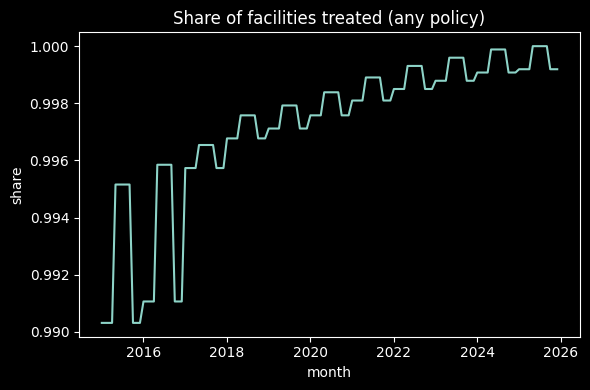

,treat_cap
month,
2025-08-01,1.000000
2025-09-01,1.000000
2025-10-01,0.999192
2025-11-01,0.999192
2025-12-01,0.999192


In [63]:
# 1) Collapse policy_monthly to one row per plant–month (any policy active = 1)
pm_any = (policy_monthly
          .groupby(['country','country_code','plant_id','month'], as_index=False)
          .agg(treat_any=('treat_any','max'),
               treat_cap=('treat_cap','max')))

# 2) Build a complete plant×month grid for the analysis window
MONTHS = pd.DataFrame({'month': pd.period_range('2015-01','2025-12', freq='M').to_timestamp()})
plants = pm_any[['country','country_code','plant_id']].drop_duplicates()
panel = (plants.merge(MONTHS, how='cross')
               .merge(pm_any, on=['country','country_code','plant_id','month'], how='left')
               .fillna({'treat_any':0, 'treat_cap':0})
               .assign(treat_any=lambda d: d['treat_any'].astype(int),
                       treat_cap=lambda d: d['treat_cap'].astype(int)))

# 3) Now compute monthly shares properly
share_treated = panel.groupby('month', as_index=False)['treat_any'].mean()
plt.figure(figsize=(6,4))
plt.plot(share_treated['month'], share_treated['treat_any'])
plt.title('Share of facilities treated (any policy)')
plt.ylabel('share'); plt.xlabel('month'); plt.tight_layout(); plt.show()

by_class = panel.groupby('month')[['treat_cap']].mean()
display(by_class.tail())

## Satellite outcome and geographic controls

In [1]:
# EE + deps
import ee, geemap
import pandas as pd
from tqdm.auto import tqdm

# EE init (auths if needed)
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

# ---- Helpers ----
DEFAULT_BUFFER_M = 1000  # used if fac doesn't have per-row 'buffer_m'

def df_to_fc(df, id_col="facility_id", lat_col="lat", lon_col="lon", buf_col="buffer_m"):
    feats = []
    for _, r in df.iterrows():
        buf = float(r[buf_col]) if buf_col in r and pd.notna(r[buf_col]) else DEFAULT_BUFFER_M
        geom = ee.Geometry.Point([float(r[lon_col]), float(r[lat_col])]).buffer(buf)
        feats.append(ee.Feature(geom, {id_col: str(r[id_col]), "buffer_m": buf}))
    return ee.FeatureCollection(feats)

FAC_ID_COL = "facility_id"
fc_fac = df_to_fc(fac, id_col=FAC_ID_COL)

# Time windows
NO2_START = "2019-01-01"  # tweak if you like
NO2_END   = "2024-06-01"  # exclusive end for monthly generator
YEARS_FOR_EMB = list(range(2018, 2025))  # annual embeddings



Successfully saved authorization token.


NameError: name 'fac' is not defined

### Join NO₂ series with policy exposure
We merge the monthly NO₂ near facilities with the corresponding **policy flags** to visualise
treated vs not-yet-treated trajectories. This is **purely descriptive** and not a causal estimate,
but it surfaces pre-trends, seasonal differences, and potential effect windows.
Here we save the multi-year panel to a Parquet file for later use.

In [ ]:
# Dataset + masking guidance per EE catalog (keep negatives except strong outliers < -0.001 mol/m^2).  [oai_citation:1‡Google for Developers](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2)
no2_ic_raw = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2") \
    .select("tropospheric_NO2_column_number_density")

def mask_outliers(img):
    v = img.select("tropospheric_NO2_column_number_density")
    return v.updateMask(v.gte(-0.001))  # mask extreme negatives per catalog note

no2_ic = no2_ic_raw.map(mask_outliers)

# Monthly means over each facility buffer
months = pd.date_range(start=NO2_START, end=NO2_END, freq="MS")

out_no2 = []
for dt_start in tqdm(months, desc="NO2 monthly"):
    dt_end = (dt_start + pd.offsets.MonthBegin(1))
    img = no2_ic.filterDate(dt_start.strftime("%Y-%m-%d"), dt_end.strftime("%Y-%m-%d")).mean().rename("no2")
    # ~1113 m nominal pixel size listed by the catalog; use 1113 for reduction scale.  [oai_citation:2‡Google for Developers](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2)
    fc_vals = img.reduceRegions(collection=fc_fac, reducer=ee.Reducer.mean(), scale=1113)
    df = geemap.ee_to_pandas(fc_vals)
    df["month"] = pd.Timestamp(dt_start)
    df = df[[FAC_ID_COL, "month", "no2"]]
    out_no2.append(df)

df_no2 = pd.concat(out_no2, ignore_index=True)

# Save (no display)
no2_path = "data/out/no2_facility_month.parquet"
df_no2.to_parquet(no2_path, index=False)
print(f"Saved NO₂ panel -> {no2_path}, rows={len(df_no2):,}, facilities={df_no2[FAC_ID_COL].nunique():,}")

ValueError: could not convert string to float: ' '

### Visualise NO₂ trajectories for a few sample facilities

In [ ]:
sample_ids = fac.sample(n=min(5, len(fac)), random_state=42)[FAC_ID_COL].astype(str).tolist()
sub = df_no2[df_no2[FAC_ID_COL].isin(sample_ids)].copy()
sub = sub.sort_values(["facility_id", "month"])

plt.figure(figsize=(8,4.5))
for fid, g in sub.groupby(FAC_ID_COL):
    plt.plot(g["month"], g["no2"], label=str(fid))
plt.title("TROPOMI NO₂ — Monthly mean in facility buffers")
plt.ylabel("tropospheric NO₂ column (mol/m²)")
plt.xlabel("Month")
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

### Build facility-year AlphaEarth embeddings and save

In [ ]:
# AlphaEarth embeddings (annual) in Earth Engine.  [oai_citation:3‡Google for Developers](https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_SATELLITE_EMBEDDING_V1_ANNUAL)
emb_ic = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")

def get_annual_emb(y:int):
    # Annual images are indexed by year; filtering by date is a safe way to grab the yearly image.
    img = emb_ic.filterDate(f"{y}-01-01", f"{y+1}-01-01").first()
    # fall back to property filter if needed: emb_ic.filter(ee.Filter.eq('year', y)).first()
    return img

emb_rows = []
for y in tqdm(YEARS_FOR_EMB, desc="Embeddings yearly"):
    img = get_annual_emb(y)
    # Use a moderate scale; AlphaEarth maps Sentinel-2 & Landsat—20 m is a practical compromise for buffers.
    fc_vals = img.reduceRegions(collection=fc_fac, reducer=ee.Reducer.mean(), scale=20)
    df = geemap.ee_to_pandas(fc_vals)
    df["year"] = y
    # Keep ID + year + all embedding bands (whatever they are named)
    keep_cols = [c for c in df.columns if c.startswith(("embedding", "b", "mean_"))]  # robust catch
    df = df[[FAC_ID_COL, "year"] + keep_cols]
    emb_rows.append(df)

df_emb = pd.concat(emb_rows, ignore_index=True)

emb_path = "data/out/alphaearth_embeddings_facility_year.parquet"
df_emb.to_parquet(emb_path, index=False)
print(f"Saved AlphaEarth embeddings -> {emb_path}, rows={len(df_emb):,}, facilities={df_emb[FAC_ID_COL].nunique():,}")

### Visualise Embeddings Around a Few Sample Facilities

In [69]:
import leafmap
import random

def alphaearth_map_for_row(row, zoom=12):
    # center on facility
    m = leafmap.maplibregl.Map(center=[float(row["lat"]), float(row["lon"])], zoom=zoom)
    # Adds a side-panel to choose AlphaEarth layers/years/styles
    m.add_alphaearth_gui()  # from leafmap's MapLibre AlphaEarth example.  [oai_citation:6‡leafmap.org](https://leafmap.org/maplibre/AlphaEarth/)
    # mark the facility
    m.add_marker(location=[float(row["lat"]), float(row["lon"])], popup=f"{row[FAC_ID_COL]}")
    return m

# Show a few sampled facilities (adjust n as you like)
n = min(4, len(fac))
rows = fac.sample(n=n, random_state=123).to_dict(orient="records")
maps = [alphaearth_map_for_row(r, zoom=12) for r in rows]
for m in maps:
    display(m)

AttributeError: module 'leafmap' has no attribute 'maplibregl'

# Final Output: Join Panel + Embeddings and Save

In [ ]:
panel = pd.read_parquet("data/out/no2_facility_month.parquet")
emb   = pd.read_parquet("data/out/alphaearth_embeddings_facility_year.parquet")

panel["year"] = panel["month"].dt.year
panel_merged = panel.merge(emb, on=[FAC_ID_COL, "year"], how="left")
panel_merged.to_parquet("data/out/panel_no2_embeddings.parquet", index=False)
print("Saved merged panel -> data/out/panel_no2_embeddings.parquet")